# Parameter choosing AT


In [1]:
# Importando tudo que já está fixo:

# Data processing
import json
import numpy as np
import pandas as pd
import re


# Topic model
import umap
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

# Dimension reduction
from umap import UMAP


# Countvectorizer (para stopwords)
from sklearn.feature_extraction.text import CountVectorizer


# German stopwords que eu alterei:
# Carregue a lista a partir do arquivo
with open("C:\\Users\\JVoigt\\OneDrive - Universität für Weiterbildung Krems\\Dokumente\\Python Scripts\\champI4.0ns\\gesetze_sammlung\\german_stopwords.json", "r") as f:
    german_stopwords_alterada = json.load(f) 


## For UMAP Analisys:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set()


from sentence_transformers import SentenceTransformer

# para montar as combinacoes:
from itertools import product

# Para a matrix 
from sklearn.metrics.pairwise import cosine_similarity

# Topic Coherence:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

## Functions to clean data:

def replace_char(x):
  return re.sub('[^a-zA-Z\süöäß]', '', x)


def clean_corpus(s):
    s = s.apply(lambda x: x.lower() if isinstance(x, str) else x)     # tolower:
    idx = s.apply(lambda x: isinstance(x, str))                       # Criar um índice booleano para filtrar os valores não-texto
    s = s.drop(idx[~idx].index)                                       # Remover os valores não-texto
    s = s.apply(replace_char)                                         # remover as partes de palavras que nao sao caracteres ou espacos
    idx = s.apply(lambda x: len(x) < 2)                               # Criar um índice booleano para filtrar os elementos com comprimento menor que 2
    s = s.drop(idx[idx].index)                                        # Remover os elementos com comprimento menor que 2
    idx = s.apply(lambda x: x == '')                                  # Criar um índice booleano para filtrar os elementos vazios
    s = s.drop(idx[idx].index)                                        # Remover os elementos vazios
    
    return s

def calculuate_coherence_score(topic_model):  
  #variable
  topic_words = topic_words = [[words for words, _ in topic_model.get_topic(topic) if words!=''] 
               for topic in range(len(set(topics))-1)]
  vectorizer = topic_model.vectorizer_model
  tokenizer = vectorizer.build_tokenizer()
  #dictionary
  tokens = [doc.split() for doc in docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]


  coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
  coherence = coherence_model.get_coherence()

  
  return coherence

# Abrindo o arquivos
df_original = pd.read_json("C:\\Users\\JVoigt\\OneDrive - Universität für Weiterbildung Krems\\Dokumente\\Python Scripts\\champI4.0ns\\gesetze_sammlung\\at_concatenado.json")

# creating parameters combinations

n = [5, 7, 10, 20]  # n_neighbors
d = [0.0, 0.1, 0.25]   # min_dist
c = [10, 15, 20, 25, 30] #min_cluster
s = [c_i/4 for c_i in c]  # min_sample

combinations = list(product(n, d, c, s))

combinations = [comb for comb in combinations if comb[3] == comb[2]/4]

c:\python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#df_original['documento'].unique()

#'digitale_aktionsplan_at', 'nationale_ki_strategie_2023_addendum_at', 'nationale_ki_strategie_2023', 'nationale_strategie_klimaziele',
df_daten_ki_at = df_original.query("documento == 'digitale_aktionsplan_at' | documento == 'nationale_ki_strategie_2023_addendum_at' | documento == 'nationale_ki_strategie_2023' | documento == 'nationale_strategie_klimaziele' ")

# 'regierungsprogramm' Onde coloco o regiuerungsprogramme? Que falaria dos dois?
df_reg_at = df_original.query("documento == 'regierungsprogramm'")

# timber and klima : 'oestereiche_holzinitiative', 'nationale_strategie_kreislaufwirtschaft'
df_kl_timber_at = df_original.query("documento == 'oestereiche_holzinitiative' | documento == 'nationale_strategie_kreislaufwirtschaft' ")

In [7]:
# vamos ver primeiro o que o regierung traz:

docs = df_reg_at['corpus']
docs = clean_corpus(docs).to_list()

In [8]:
### início do loop: rodando todas as combinacoes de parâmetros para fazer o meu modelo:

df = pd.DataFrame({'parameters': [],'n_neighbors': [], 'min_dist': [], 'min_cluster' : [], 
                      'min_sample': [], 'topic_coherence': [], 'nr_topics': [], 'avg_similarity' : [], 'topics': []})

for comb in combinations:
    n_neighbors = comb[0]
    min_dist = comb[1]
    min_cluster = comb[2]
    min_sample = int(comb[3])



    umap_model  = UMAP(n_neighbors=n_neighbors, 
                            min_dist = min_dist,
                            n_components=5, 
                            metric='cosine', random_state=42)


    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, 
                            min_samples = min_sample, 
                            metric='euclidean', 
                            prediction_data=True)

    vectorizer_model = CountVectorizer(stop_words=german_stopwords_alterada) #german_stop_words alterada

    topic_model = BERTopic(language = "german", vectorizer_model=vectorizer_model, 
                        umap_model=umap_model, 
                        hdbscan_model=hdbscan_model).fit(docs)

    topics, probs = topic_model.fit_transform(docs)

    # Matrix de similaridade:

    matrixA = cosine_similarity(np.array(topic_model.topic_embeddings_)[1:, :])
    avg_similarity = np.average(matrixA)
    labels = (topic_model.get_topic_info().sort_values("Topic", ascending=True).Name)[1:]
    nr_topics = len(labels)
    labels = labels.str.cat(sep='; ')
    title = 'n_neighbors = ' + str(n_neighbors) + ' min_dist = ' + str(min_dist) + ' min_cluster = ' + str(min_cluster) + ' min_sample = ' + str(min_sample)
    
    #coherence score:
    cs = calculuate_coherence_score(topic_model)

    df_temp = pd.DataFrame({'parameters': [title],
                            'n_neighbors': [n_neighbors],
                            'min_dist': [min_dist],
                            'min_cluster' : [min_cluster],
                            'min_sample': [min_sample], 
                            'topic_coherence': [cs],
                            'nr_topics': [nr_topics],
                            'avg_similarity' : [avg_similarity],
                            'topics': [labels]})
    

    pd.DataFrame({'parameters': [], 
                       'nr_topics': [], 'avg_similarity' : [], 'topics': []})


    df = pd.concat([df, df_temp])

    
df.to_csv("df_avg_similarity_coerence_coeficient_at_regierungsprograme.csv", sep = ';', index = False, )

In [9]:
df1 = df
df1 = df1.sort_values('avg_similarity')
df1.head()

,parameters,n_neighbors,min_dist,min_cluster,min_sample,topic_coherence,nr_topics,avg_similarity,topics
0,n_neighbors = 5 min_dist = 0.0 min_cluster = 1...,5.0,0.0,10.0,2.0,0.351592,33.0,0.756523,0_umsetzung_ebene_europa_green; 1_digitale_dig...
0,n_neighbors = 5 min_dist = 0.1 min_cluster = 1...,5.0,0.1,10.0,2.0,0.342425,32.0,0.760024,0_schulen_pädagogen_pädagogischen_weiterentwic...
0,n_neighbors = 7 min_dist = 0.0 min_cluster = 1...,7.0,0.0,10.0,2.0,0.370446,33.0,0.762358,0_pädagogen_schulen_elementarpädagogik_weitere...
0,n_neighbors = 20 min_dist = 0.0 min_cluster = ...,20.0,0.0,10.0,2.0,0.384911,25.0,0.766448,0_österreich_österreichischen_österreichs_kuns...
0,n_neighbors = 7 min_dist = 0.1 min_cluster = 1...,7.0,0.1,10.0,2.0,0.371797,26.0,0.781029,0_österreich_österreichischen_migration_intern...


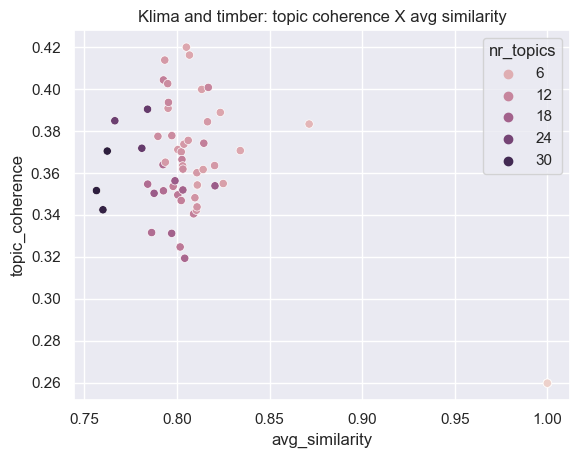

In [10]:
# Verificando a dispersao:

import seaborn as sns
import matplotlib.pyplot as plt

# criando o gráfico de dispersão
sns.scatterplot(data=df1, x='avg_similarity', y='topic_coherence', hue='nr_topics')

# adicionando labels de eixo
plt.xlabel('avg_similarity')
plt.ylabel('topic_coherence')

# adicionando título
plt.title("Klima and timber: topic coherence X avg similarity")

# exibindo o gráfico
plt.show()

### Segunda parte

In [11]:
# topic_coherence > 0.40 & avg_similarity < 0.80
df1 = pd.read_csv("df_avg_similarity_coerence_coeficient_at_regierungsprograme.csv", sep = ';')
df1 = df.query('topic_coherence > 0.40 & avg_similarity < 0.80')
df1 = df1.reset_index()

combinations = []

for i in range(0,len(df1)):
    n = df1.iloc[i, 2]  # linha coluna
    d = df1.iloc[i, 3]
    c = int(df1.iloc[i, 4])
    s = int(df1.iloc[i, 5])
    
    com = [(n, d, c, s)]

    combinations.extend(com)

for comb in combinations:
    print(comb)

(5.0, 0.1, 25, 6)
(7.0, 0.1, 20, 5)
(10.0, 0.1, 20, 5)


In [12]:
# Dados

docs = df_reg_at['corpus']
docs = clean_corpus(docs).to_list()

### início do loop:

df2 = pd.DataFrame({'Document': [],'Topic': [], 'Name': [], 'Top_n_words' : [], 'Probability': [], 'Representative_document': [], 'model': []})

for comb in combinations:
    print(comb)


    n_neighbors = int(comb[0])
    min_dist = int(comb[1])
    min_cluster = int(comb[2])
    min_sample = int(comb[3])


    umap_model  = UMAP(n_neighbors=n_neighbors, 
                            min_dist = min_dist,
                            n_components=5, 
                            metric='cosine', random_state=42)


    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, 
                            min_samples = min_sample, 
                            metric='euclidean', 
                            prediction_data=True)

    vectorizer_model = CountVectorizer(stop_words=german_stopwords_alterada) #german_stop_words alterada

    topic_model = BERTopic(language = "german", vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model).fit(docs)

    topics, probs = topic_model.fit_transform(docs)

    # Dataframe with representative examples:

    df_temp = topic_model.get_document_info(docs)
    df_temp = df_temp.query('Representative_document == True')

    #confirmando o modelo desse df
    position = combinations.index(comb)
    position = str(position)

    #add modelo
    df_temp['model'] = 'model ' + position

    df2 = pd.concat([df2, df_temp], axis=0)

        ##### Visualizacao dos resultados

    title = 'EU_Daten_ki_n_neighbors = ' + str(n_neighbors) + ' min_dist = ' + str(min_dist) + ' min_cluster = ' + str(min_cluster) + ' min_sample = ' + str(min_sample)

    fig_1 = topic_model.visualize_heatmap()
    fig_1.update_layout(title = title)

    ############################################Visualizacao da distribuicao

    sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")   #Suitable Score Functions: cosine
    embeddings = sentence_model.encode(docs, show_progress_bar=False)


    # Train BERTopic
    topic_model = BERTopic(language = "german", 
                            umap_model=umap_model,
                            vectorizer_model=vectorizer_model,
                            hdbscan_model=hdbscan_model).fit(docs, embeddings)


    # Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
    reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)
    fig_2 = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings)
    fig_2.update_layout(title = title)

    title = re.sub(r'\s', '_', title) + '.html'

    with open(title, 'a') as f:
        f.write(fig_1.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_2.to_html(full_html=False, include_plotlyjs='cdn'))

(5.0, 0.1, 25, 6)
(7.0, 0.1, 20, 5)
(10.0, 0.1, 20, 5)


In [13]:
df2.to_csv("df_examples_models_at_regierung.csv", sep = ';', index = False, )

In [18]:
df2.groupby(['model', 'Topic', 'Name'])['Topic'].count()

model    Topic  Name                                                              
model 0  0.0    0_schulen_weiterentwicklung_pädagogen_hochschulen                     3
         1.0    1_bundesregierung_maßnahmen_klimaschutz_sollen                        3
         2.0    2_österreich_österreichischen_österreichs_europäischen                3
         3.0    3_österreich_euro_menschen_bzw                                        3
         4.0    4_verkehr_tourismus_öffentlichen_einsatz                              3
         5.0    5_evaluierung_stärkung_schaffung_insbesondere                         3
         6.0    6_prüfung_bzw_rechenschaftsberichts_informationen                     3
         7.0    7_umsetzung_europa_bundesregierung_maßnahmen                          3
         8.0    8_pflege_familien_ausbau_kinder                                       3
         9.0    9_forschung_bereich_österreich_österreichischen                       3
         10.0   10_digitalisierung_di